### 必要なライブラリのインポート

In [ ]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import preprocessing
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
import datetime
pd.set_option('display.max_columns', None)
from operator import itemgetter
import time
import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
import string
from textblob import TextBlob
import nltk

### データセットのインポート

In [2]:
train_data = pd.read_csv("../kaggle_datasets/mercari/train.tsv",delimiter='\t')
test_data = pd.read_csv("../kaggle_datasets/mercari/test.tsv",delimiter='\t')

In [3]:
train_data.shape,test_data.shape

((1482535, 8), (693359, 7))

In [4]:
train_data[0:5]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
train_data.info(),test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


(None, None)

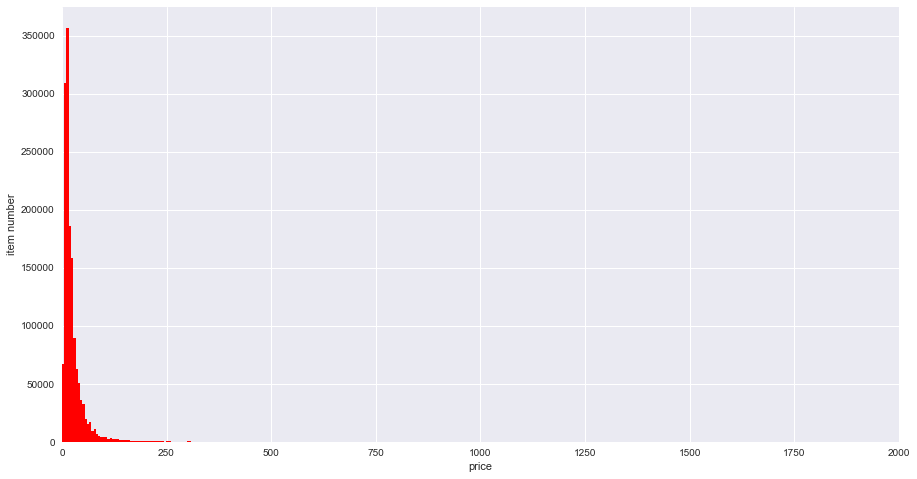

In [6]:
figure = plt.figure(figsize=(15,8))
plt.hist(train_data["price"], stacked=True, color = ['r'], bins = round(len(train_data)/4000),label = 'train_data')
plt.xlim(0,2000)
plt.xlabel('price')
plt.ylabel('item number')
plt.show()

### 価格が上位1%のアイテムのcategory_nameを取得

In [7]:
#train_dataを価格順に並べ替え
train_data_sort = train_data.sort_values(by=["price"], ascending=False)
top1per_price = train_data_sort["price"][0:round(len(train_data)*0.01)]
print("上位1%は$",top1per_price.values[-1],"まで")

top1per_category = train_data_sort["category_name"][0:round(len(train_data)*0.01)]
print("上位のcategory_name")
print(top1per_category.values[:30])
print("上位1%のカテゴリ数は",len(set(top1per_category)))

上位1%は$ 170.0 まで
上位のcategory_name
["Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Messenger & Crossbody" 'Women/Jewelry/Rings'
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Messenger & Crossbody" 'Women/Jewelry/Rings'
 'Beauty/Makeup/Face' "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Messenger & Crossbody"
 "Women/Women's Accessories/Watches"
 'Electronics/Cell Phones & Accessories/Cell Phone Accessories'
 'Electronics/Computers & Tablets/iPad/Tablet/eBook Readers'
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Backpack Style"
 "Women/Women's Handbags/Shoulder Bag"
 "Women/Women's Handbags/Shoulder Bag" 'Women/Jewelry/Rings'
 "Women/Women's Handbags/Satchel" 'Women/Jewelry/Rings'
 "Women/Women's Accessories/Watches" "Women/Women's Handbags/Shoulder Bag"
 'Handmade/Bags and Purses/Purse' 'Women/Jewelry/Ne

### 特に価格の高いカテゴリをlistで再定義し、それ以外をother_listに包括

In [8]:
electronics_phone_list = [
    'Electronics/Cell Phones & Accessories/Cell Phone Accessories',
    'Electronics/Cell Phones & Accessories/Cell Phones & Smartphones',
    'Electronics/Computers & Tablets/iPad/Tablet/eBook Readers',
    'Electronics/Computers & Tablets/Laptops & Netbooks',
    'Electronics/Computers & Tablets/iPad/Tablet/eBook Access'
    ]

electronics_camera_list = [
    'Electronics/Cameras & Photography/Camera & Photo Accessories',
    'Electronics/Cameras & Photography/Digital Cameras'
    ]

bag_list = [
    "Women/Women's Handbags/Shoulder Bag",
    "Women/Women's Handbags/Messenger & Crossbody",
    "Women/Women's Handbags/Backpack Style",
    "Women/Women's Handbags/Totes & Shoppers",
    'Vintage & Collectibles/Bags and Purses/Luggage',
    "Vintage & Collectibles/Bags and Purses/Purse"
    ]

jewelry_list = [
    'Women/Jewelry/Rings',
    "Women/Women's Accessories/Watches",
    'Women/Jewelry/Necklaces'
    ]

make_up_list = [
    'Beauty/Makeup/Lips',
    'Beauty/Makeup/Makeup Sets',
    'Beauty/Skin Care/Face',
    'Beauty/Makeup/Makeup Palettes'
    ]

kids_list = [
    'Kids/Toys/Electronics for Kids',
    'Kids/Boys 0-24 Mos/One-Pieces',
    'Kids/Girls 2T-5T/Coats & Jackets',
    'Kids/Girls (4+)/Shoes',
    'Kids/Diapering/Wipes & Holders',
    'Kids/Girls 0-24 Mos/Shoes',
    'Kids/Toys/Learning & Education',
    'Kids/Nursery/Bedding',
    'Kids/Girls (4+)/Coats & Jackets',
    'Kids/Boys 2T-5T/Shoes',
    'Kids/Girls (4+)/Tops & T-Shirts',
    'Kids/Toys/Arts & Crafts'
    ]

concat_data = pd.concat([train_data,test_data],axis=0)
other_list = list(concat_data["category_name"][~concat_data["category_name"].isin(
    jewelry_list+
    bag_list+
    electronics_camera_list+
    electronics_phone_list+
    make_up_list+
    kids_list
    )].dropna().values)
other_list = list(set(other_list))



### 学習用のtrain_data_x、train_data_yを作成するための関数を定義

In [9]:
def make_train_data(train_data,test_data,category_list):
    #データの取得
    train_data = train_data[train_data["category_name"].isin(category_list)]
    test_data = test_data[test_data["category_name"].isin(category_list)]
    #再index
    train_data = pd.concat([train_data,test_data],axis=0)
    train_data = train_data.reset_index(drop = True)
    #価格順に並び替え
    df_ascend = train_data.sort_values(by=["price"], ascending=False)
    
    #brand_nameのダミー
    #上位1%のbrand_nameは教師データとして利用し、それ以外のbrand_nameは"other-brand"に置換
    brand_list = df_ascend["brand_name"][0:round(len(train_data)*0.01)]
    brand_list_name = brand_list.values
    train_data_brand_name = train_data["brand_name"].fillna("NoData") 
    train_data_brand_name[~train_data_brand_name.isin(brand_list)] =  "others-brand"
    brand_name_dummies = pd.get_dummies(train_data_brand_name)
    brand_name_dummies = pd.DataFrame(brand_name_dummies)

    #category_nameのダミー
    #全てのcategory_nameをダミー化する
    category_list = df_ascend["category_name"][0:len(train_data)]
    category_list_name = category_list.values
    train_data_category_name = train_data["category_name"].fillna("NoData")    
    category_name_dummies = pd.get_dummies(train_data_category_name)
    category_name_dummies = pd.DataFrame(category_name_dummies)

    #教師データtrain_data_yの定義
    train_data_y = train_data["price"].dropna()
    
    #concat
    train_id = train_data["train_id"]
    test_id = train_data["test_id"]
    test_id = test_id.dropna().values
    
    train_data.drop(["name","category_name","brand_name","price","item_description"],axis=1,inplace=True)
    item_dummy = pd.get_dummies(train_data["item_condition_id"])
    item_dummy.columns = ["1.0","2.0","3.0","4.0","5.0"]
    
    train_data_x = pd.concat([train_data["shipping"],train_data["train_id"],train_data["test_id"],item_dummy,brand_name_dummies,category_name_dummies],axis=1)
    
    train_data_x.drop("test_id",axis=1,inplace=True)
    train_data_x = train_data_x.dropna()
    train_data_x.drop("train_id",axis=1,inplace=True)
    
    #test用のtest_data_xの作成
    test_data_x = pd.concat([train_data["shipping"],train_data["train_id"],train_data["test_id"],item_dummy,brand_name_dummies,category_name_dummies],axis=1)
    test_data_x.drop("train_id",axis=1,inplace=True)
    test_data_x = test_data_x.dropna()
    test_data_x.drop("test_id",axis=1,inplace=True)
    test_data_x.index = test_id
    
    return train_data_x,train_data_y,test_data_x,test_id

### category_nameがnanのデータについても別途学習用のデータを定義

In [10]:
def make_train_data_null_category(train_data,test_data):
    #データの取得
    train_data = train_data[train_data["category_name"].isnull()]
    test_data = test_data[test_data["category_name"].isnull()]
    #再index
    train_data = pd.concat([train_data,test_data],axis=0)
    train_data = train_data.reset_index(drop = True)
    #並び替え
    df_ascend = train_data.sort_values(by=["price"], ascending=False)
    
    #brand_nameのダミー
    brand_list = df_ascend["brand_name"][0:round(len(train_data)*0.1)]
    brand_list_name = brand_list.values
    train_data_brand_name = train_data["brand_name"].fillna("NoData")
    train_data_brand_name[~train_data_brand_name.isin(brand_list)] =  "others-brand"
    brand_name_dummies = pd.get_dummies(train_data_brand_name)
    brand_name_dummies = pd.DataFrame(brand_name_dummies)
    
    
    #category_nameのダミー=null
    
    #train_data_y
    train_data_y = train_data["price"].dropna()
    
    #concat
    train_id = train_data["train_id"]
    test_id = train_data["test_id"]
    test_id = test_id.dropna().values
    
    train_data.drop(["name","category_name","brand_name","price","item_description"],axis=1,inplace=True)
    item_dummy = pd.get_dummies(train_data["item_condition_id"])
    item_dummy.columns = ["1.0","2.0","3.0","4.0","5.0"]
    
    train_data_x = pd.concat([train_data["shipping"],train_data["train_id"],train_data["test_id"],item_dummy,brand_name_dummies],axis=1)
    
    train_data_x.drop("test_id",axis=1,inplace=True)
    train_data_x = train_data_x.dropna()
    train_data_x.drop("train_id",axis=1,inplace=True)
    
    test_data_x = pd.concat([train_data["shipping"],train_data["train_id"],train_data["test_id"],item_dummy,brand_name_dummies],axis=1)
    test_data_x.drop("train_id",axis=1,inplace=True)
    test_data_x = test_data_x.dropna()
    test_data_x.drop("test_id",axis=1,inplace=True)
    test_data_x.index = test_id
    
    return train_data_x,train_data_y,test_data_x,test_id

### Xgboostを用いた学習用の関数と予測データをoutputするための関数を定義

In [11]:
def train_and_output(train_data_x,train_data_y,test_data_x):
    #train
    #feature_names = list(train_data_x)
    #dtrain = xgb.DMatrix(train_data_x.as_matrix(),label=train_data_y.tolist(), feature_names = feature_names)
    #df_x_train = xgb.DMatrix(train_data_x)
    #df_y_train = xgb.DMatrix(train_data_y)
    mod = xgb.XGBRegressor(learning_rate=0.1,max_depth=10,n_estimators=20)
    mod.fit(train_data_x, train_data_y)
    
    #predict
    y_test_pred = mod.predict(test_data_x)
    df_y_test = pd.DataFrame()
    df_y_test_pred = pd.DataFrame(y_test_pred)
    df_y_test_pred.index = test_data_x.index
    
    df_output = pd.DataFrame()
    df_output["test_id"] = df_y_test_pred.index
    df_output["price"] = df_y_test_pred.values
    
    return df_output

### 定義したlist、other_list、nanカテゴリー別に学習と予測結果のoutputを実施

In [12]:
#定義したlist
category_list_high = jewelry_list,bag_list,electronics_camera_list,electronics_phone_list,make_up_list,kids_list

#high_price
df_result_high = pd.DataFrame()
for category in category_list_high:
    train_data = train_data
    test_data = test_data
    make_data = make_train_data(train_data,test_data,category)
    df_output = train_and_output(make_data[0],make_data[1],make_data[2])
    df_result_high = pd.concat([df_result_high,df_output],axis=0)
    print(category)

['Women/Jewelry/Rings', "Women/Women's Accessories/Watches", 'Women/Jewelry/Necklaces']
["Women/Women's Handbags/Shoulder Bag", "Women/Women's Handbags/Messenger & Crossbody", "Women/Women's Handbags/Backpack Style", "Women/Women's Handbags/Totes & Shoppers", 'Vintage & Collectibles/Bags and Purses/Luggage', 'Vintage & Collectibles/Bags and Purses/Purse']
['Electronics/Cameras & Photography/Camera & Photo Accessories', 'Electronics/Cameras & Photography/Digital Cameras']
['Electronics/Cell Phones & Accessories/Cell Phone Accessories', 'Electronics/Cell Phones & Accessories/Cell Phones & Smartphones', 'Electronics/Computers & Tablets/iPad/Tablet/eBook Readers', 'Electronics/Computers & Tablets/Laptops & Netbooks', 'Electronics/Computers & Tablets/iPad/Tablet/eBook Access']
['Beauty/Makeup/Lips', 'Beauty/Makeup/Makeup Sets', 'Beauty/Skin Care/Face', 'Beauty/Makeup/Makeup Palettes']
['Kids/Toys/Electronics for Kids', 'Kids/Boys 0-24 Mos/One-Pieces', 'Kids/Girls 2T-5T/Coats & Jackets', 'Ki

In [13]:
#other_listの学習
df_result_normal = pd.DataFrame()

j = len(other_list)
unit = 70

for k in range(50):
    if k*unit > j:
        break

for i in range(k):
    s = unit*i
    category = other_list[unit*i:s+unit]
#normal_priceとして出力
    train_data = train_data
    test_data = test_data
    make_data = make_train_data(train_data,test_data,category)
    df_output = train_and_output(make_data[0],make_data[1],make_data[2])
    df_result_normal = pd.concat([df_result_normal,df_output],axis=0)
    print(i,"回目")

0 回目
1 回目
2 回目
3 回目
4 回目
5 回目
6 回目
7 回目
8 回目
9 回目
10 回目
11 回目
12 回目
13 回目
14 回目
15 回目
16 回目
17 回目
18 回目


In [14]:
#null_category_price
df_result_null = pd.DataFrame()
train_data = train_data
test_data = test_data
make_data = make_train_data_null_category(train_data,test_data)
df_output = train_and_output(make_data[0],make_data[1],make_data[2])
df_result_null = pd.concat([df_result_null,df_output],axis=0)

In [15]:
#3通りの出力を結合して並び替え
df_result = pd.concat([df_result_high,df_result_normal,df_result_null],axis=0)
df_result_high.sort_values(by=["price"], ascending=False)
df_sort = df_result.sort_values(by=["test_id"], ascending=True)
df_sort = df_sort.assign(test_id = df_sort["test_id"].astype(np.int32))
df_sort

,test_id,price
0,0,11.832755
0,1,9.064403
0,2,90.069901
0,3,16.446068
0,4,11.739799
1,5,10.057384
1,6,34.960880
2,7,24.233337
0,8,21.334505
0,9,11.908314


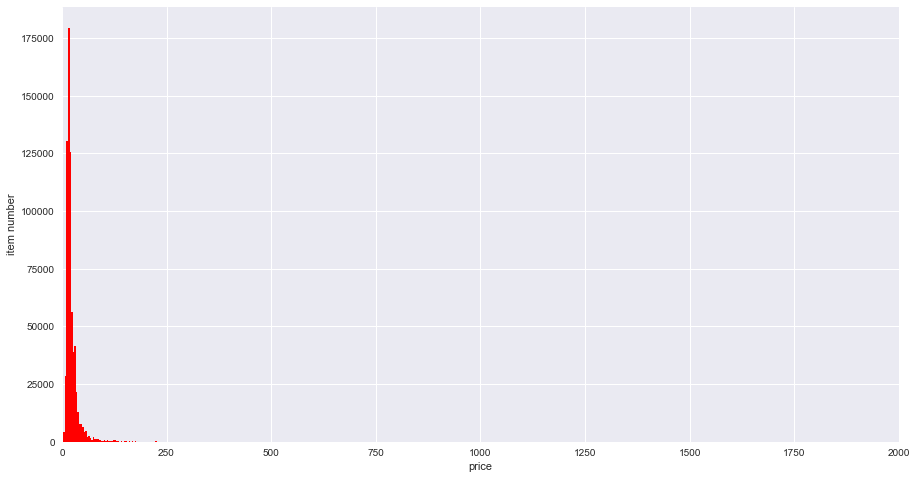

In [16]:
figure = plt.figure(figsize=(15,8))
plt.hist(df_sort["price"], stacked=True, color = ['r'], bins = round(len(df_sort)/4000),label = 'df_sort')
plt.xlim(0,2000)
plt.xlabel('price')
plt.ylabel('item number')
plt.show()

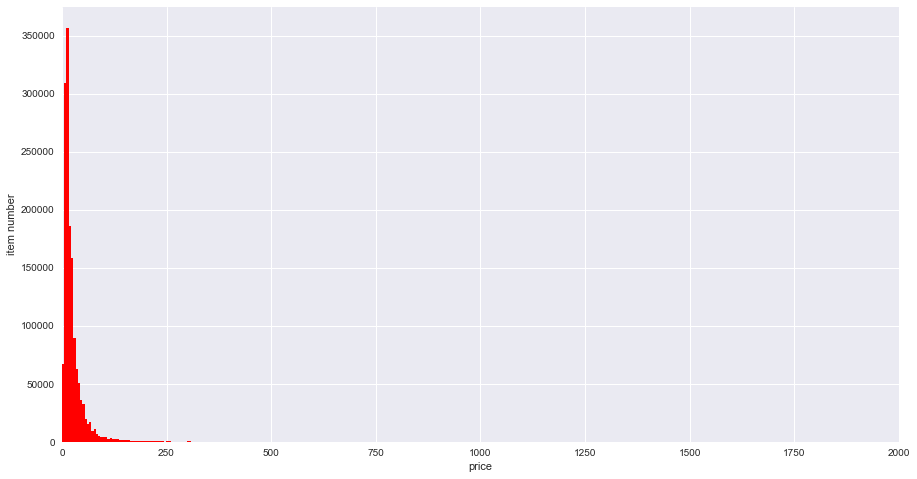

In [17]:
figure = plt.figure(figsize=(15,8))
plt.hist(train_data["price"], stacked=True, color = ['r'], bins = round(len(train_data)/4000),label = 'train_data')
plt.xlim(0,2000)
plt.xlabel('price')
plt.ylabel('item number')
plt.show()